# READ FIRST
Parts 1-3 documents the progress working through the tracking algorithm. If you're just running the final tracking code, refer to just part 4 onwards!

In [1]:
import numpy as np
from PIL import Image
from scipy.spatial import distance
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt
from munkres import Munkres

# Part 1: Data Preparation

## 1.1: Load detection and embedding data

In [9]:
# Load the detection and embedding file

# Detection format: list<tuple>
# (<camera ID>, <Frame ID>, <class>, <x1>, <y1>, <x2>, <y2>, <confidence score>)
detection = np.loadtxt('detection.txt',delimiter=',',dtype=None)

# Embedding format: list<tuple>
# feature map, len 512
embedding = np.load('embedding.npy', allow_pickle=True)

In [10]:
# Format detections by video number
# key: video number (71-73 for training, 74 for validation, 75 for tesing)
# val: detection tuple (for detections) or embedding features (for embeddings)
detections = {}
embeddings = {}

for vid_num in range(71, 76):
    inds = detection[:,0] == vid_num
    temp_detect = detection[inds]
    temp_embed = embedding[inds]
    sort_inds = temp_detect[:, 1].argsort()
    detections[vid_num] = temp_detect[sort_inds]
    embeddings[vid_num] = temp_embed[sort_inds]

## 1.2: Create data visualization functions

In [5]:
# Show an image from a specified camera and detection number
def show_detection_img(video_num, detection_num):
    camera,frame,_,x1,y1,x2,y2,_ = detections[video_num][detection_num]
    image = Image.open('c0{}/img/{}.jpg'.format(video_num, '%05d'%frame)).crop((x1,y1,x2,y2))
    return image

# Show an image from the detection data
def show_img(det):
    return Image.open('c0{}/img/{}.jpg'.format(int(det[0]), '%05d'%det[1])).crop((det[3], det[4], det[5], det[6]))

In [6]:
# Print the cosine distance between two detections and display them side by side
def show_distance(v1, d1, v2, d2):
    cos_dist = distance.cosine(embeddings[v1][d1], embeddings[v2][d2])
    print(f"Cosine distance between two detections: {cos_dist}")
    fig, axs = plt.subplots(1, 2)
    axs[0].axis('off')
    axs[0].imshow(show_detection_img(v1, d1))
    axs[1].axis('off')
    axs[1].imshow(show_detection_img(v2, d2))

Cosine distance between two detections: 0.0018007755279541016


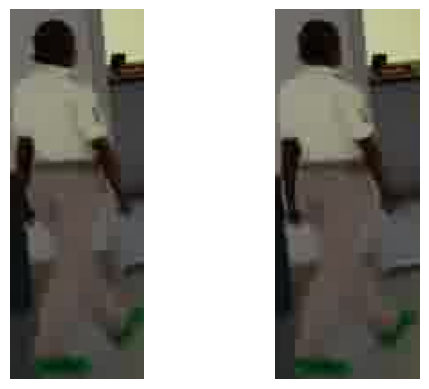

In [7]:
show_distance(74, 1501, 74, 1502)

In [133]:
# Get the detection data of all detections in a specified frame
def get_frame_info(vid_num, frame_num):
    dets = detections[vid_num]
    embs = embeddings[vid_num]
    inds = dets[:, 1] == frame_num
    frame_dets = dets[inds]
    frame_embs = embs[inds]
    return list(zip(frame_dets, frame_embs))

In [134]:
# Show the detections in a frame
def show_frame_dets(vid_num, frame_num):
    print("Original Frame:")
    display(Image.open("c0{}/img/{}.jpg".format(vid_num, '%05d'%frame_num)))
    print("Detections:")
    frame_info = get_frame_info(vid_num, frame_num)
    fig, axs = plt.subplots(1, len(frame_info))
    for i, det in enumerate(frame_info):
        camera,frame,_,x1,y1,x2,y2,_ = det[0]
        img = Image.open('c0{}/img/{}.jpg'.format(vid_num, '%05d'%frame_num)).crop((x1,y1,x2,y2))
        axs[i].axis('off')
        axs[i].imshow(img)

Original Frame:


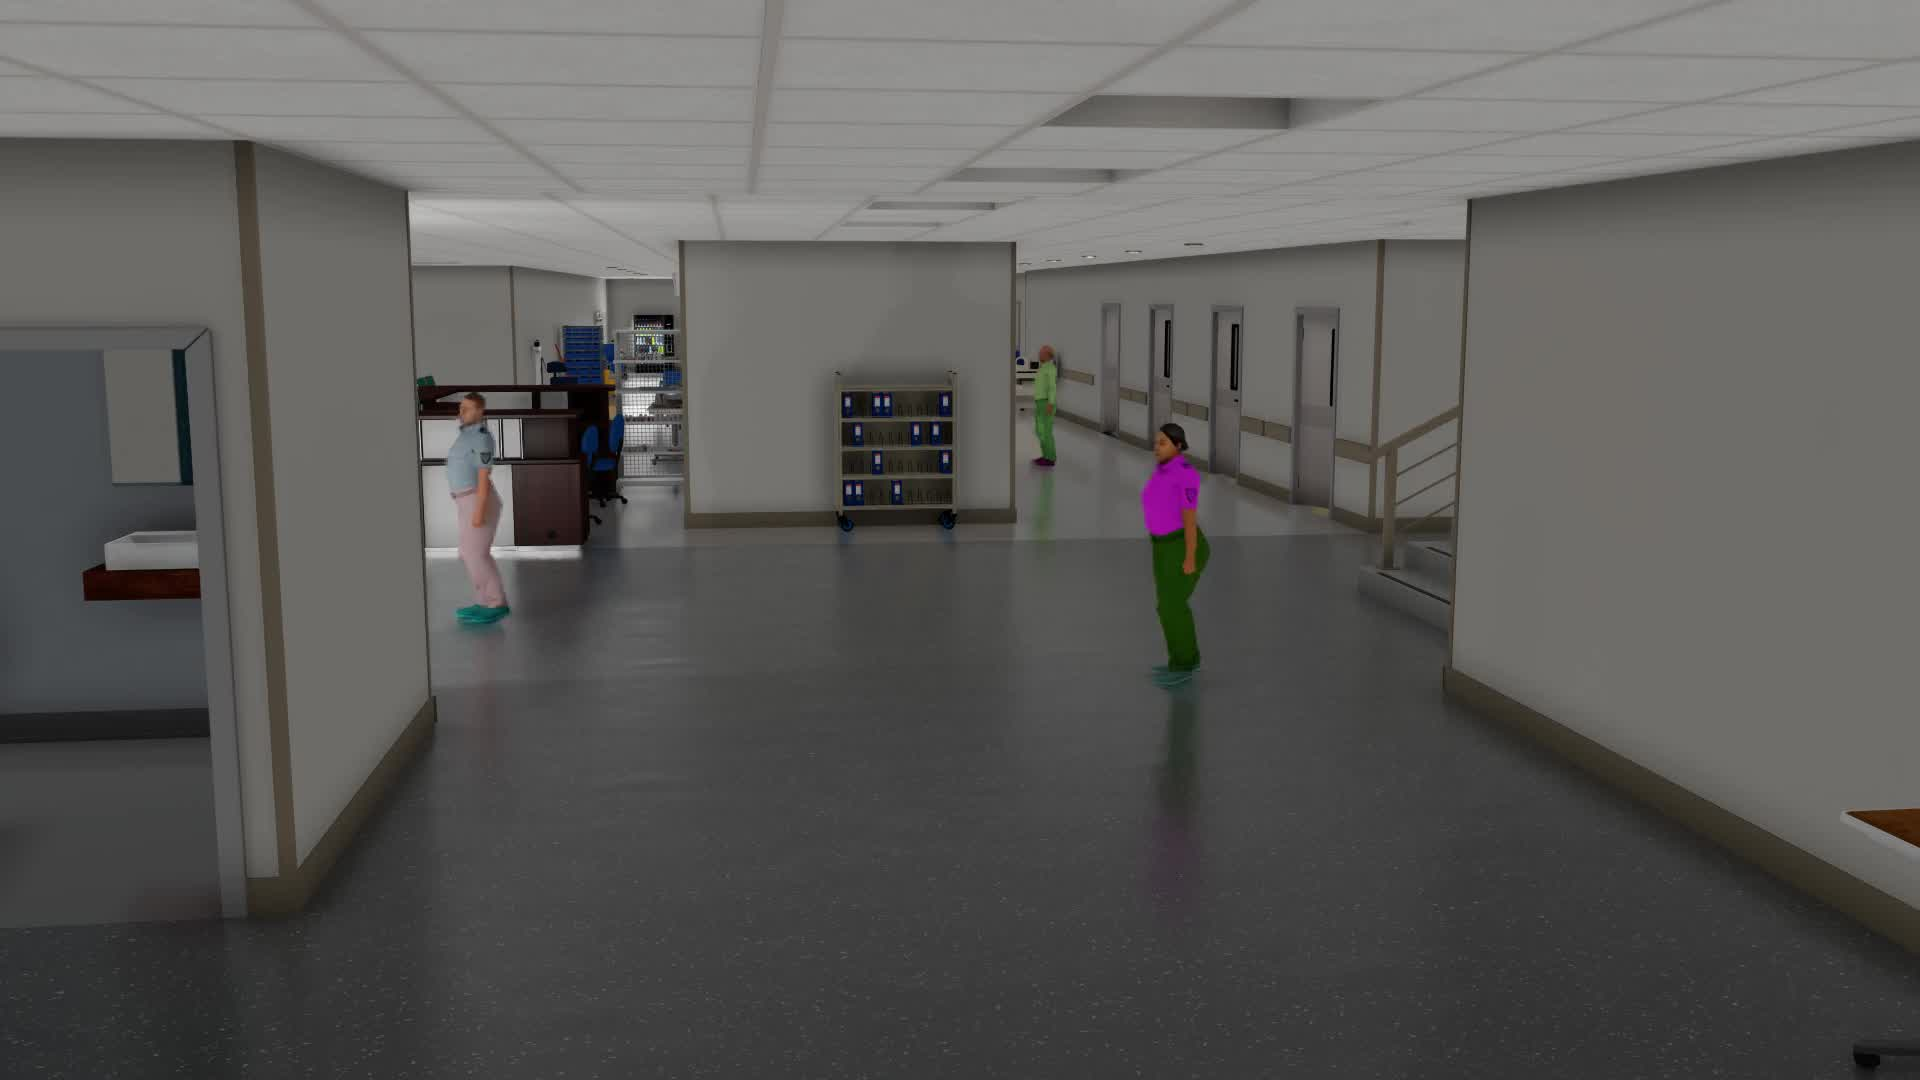

Detections:


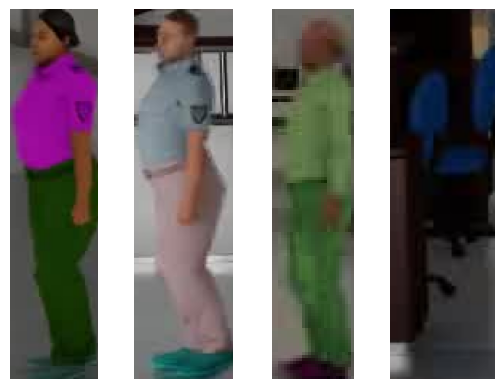

In [140]:
show_frame_dets(75, 5)

# Part 2: Tracking

## 2.1: Association function

In [12]:
class Det_obj(tuple):
    def __new__(self, detection, trackID=-1):
        """
        Detection input format:
        (<camera ID>, <Frame ID>, <class>, <x1>, <y1>, <x2>, <y2>, <confidence score>)
        
        Output detection object format:
        (<camera ID>, <tracking ID>, <Frame ID>, <x1>, <y1>, <x2>, <y2>, -1, -1)
        """
        assert len(detection) == 8, "Detection input has length 8 with format (<camera ID>, <Frame ID>, <class>, <x1>, <y1>, <x2>, <y2>, <confidence score>)"
        output = list(detection)
        output[2] = output[1]
        output[1] = trackID
        output[-1] = -1
        output.append(-1)
        return tuple.__new__(Det_obj, tuple(output))

In [12]:
# Associate detections between current frame (detection) and
# previous frame (tracking). Return pairs of matching detection
# objects or singular new objects
def association(vid_num, frame_num, prev_frame, next_id):
    # Format: frame = list[tuple], tuple = (detection, embedding)
    # curr_frame has detection tuple, prev_frame has detection
    # object!!!
    curr_frame = get_frame_info(vid_num, frame_num)
    
    # Calculate cost matrix, rows are current frame detections, 
    # columns are previous frame detections
    cost_matrix = []
    for i in curr_frame:
        curr_frame_costs = []
        for j in prev_frame:
            curr_frame_costs.append(distance.cosine(i[1], j[1]))
        cost_matrix.append(curr_frame_costs)
    
    # No detections in current frame
    if not cost_matrix:
        return [], next_id

    # Hungarian method for least cost
    m = Munkres()
    coords = m.compute(cost_matrix)
    
    # No detections in previous frame
    if not coords:
        pairs = []
        for det, emb in curr_frame:
            pairs.append((None, (Det_obj(det, next_id), emb)))
            next_id += 1
        return pairs, next_id
    
    # Pair prev/curr frame detections together
    pairs = []
    i = 0
    for curr, prev in coords:   
        # If new detection, insert (None, curr_detection)
        if curr != i:
            pairs.append((None, (Det_obj(curr_frame[i][0], next_id), curr_frame[i][1])))
            next_id += 1
        else:
            pairs.append((prev_frame[prev], (Det_obj(curr_frame[curr][0], prev_frame[prev][0][1]), prev_frame[prev][1])))
        i += 1
    return pairs, next_id

In [13]:
def show_pairs(pairs):
    for prev, curr in pairs:
        if prev is None:
            print("New detection:")
            ax = plt.subplot()
            ax.axis('off')
            ax.imshow(show_img(curr[0]))
            plt.show()
        else:
            print("prev/curr detection pair")
            fig, axs = plt.subplots(1, 2)
            axs[0].axis('off')
            axs[0].imshow(show_img(prev[0]))
            axs[1].axis('off')
            axs[1].imshow(show_img(curr[0]))
            plt.show()

prev/curr detection pair


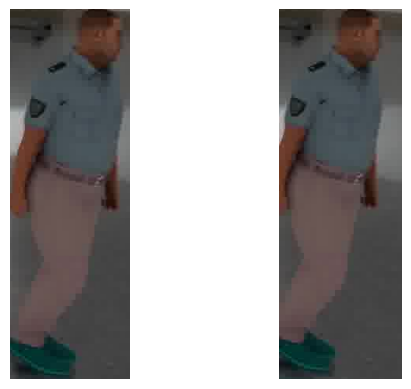

prev/curr detection pair


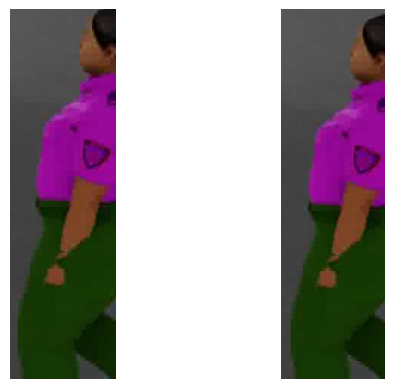

prev/curr detection pair


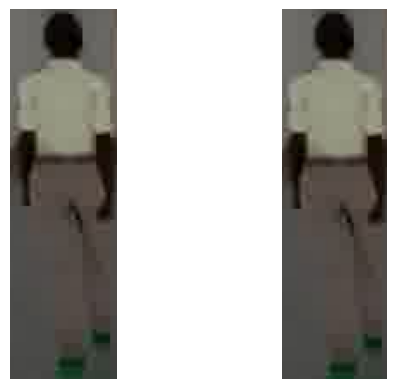

In [14]:
frame = 15000
pairs, _ = association(74, frame, get_frame_info(74, frame-1), 0)
show_pairs(pairs)

## 2.2: Track ID of each person

In [15]:
def track(vid_num):
    # Track each person and keep detections in a list under that ID
    # Key: ID number
    # Value: list[detections]
    IDs = {}
    next_id = 0
    prev_frame = []
    for frame in range(0, 18010):
        pairs, next_id = association(vid_num, frame, prev_frame, next_id)
        for _, curr_det_emb in pairs:
            curr_det = curr_det_emb[0]
            if not curr_det[1] in IDs:
                IDs[curr_det[1]] = []
            IDs[curr_det[1]].append(curr_det)
        prev_frame = [curr for _, curr in pairs]
        
    return IDs

In [16]:
tracking_output_74 = track(74)

In [5]:
def show_track_id(track_id_outputs, track_id):
    outputs = track_id_outputs[track_id]
    fig, axs = plt.subplots(len(outputs)//10 + 1, 10)
    for ind in range((len(outputs)//10 + 1) * 10):
        if len(outputs) < 10:
            axs[ind].axis('off')
            if ind < len(outputs):
                det = outputs[ind]
                axs[ind].imshow(Image.open('c0{}/img/{}.jpg'.format(int(det[0]), '%05d'%det[1])).crop((det[3], det[4], det[5], det[6])))
        else:
            axs[ind // 10, ind % 10].axis('off')
            if ind < len(outputs):
                det = outputs[ind]
                axs[ind // 10, ind % 10].imshow(Image.open('c0{}/img/{}.jpg'.format(int(det[0]), '%05d'%det[1])).crop((det[3], det[4], det[5], det[6])))
    plt.show()

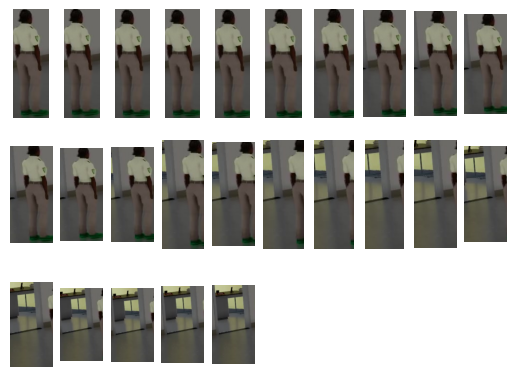

In [18]:
show_track_id(tracking_output_74, 2)

# Part 3: ReID Post-Processing

In [ ]:
"""
TODO:
ReID needs to 
1. Reidentify people who have walked out and back into frame
2. Account for skipped frames (i.e. detection doesn't catch frame(s) in between when person is fully
    on screen, ReID needs to count them as the person)
    
Potential ideas:
    1. Triplet loss
    2. One shot detection against sample from each existing ID (intensive, needs a new model to be trained)
    3. ?
"""

# Part 4: Putting it all together

Once complete, only need to run cells under this section! Don't bother running everything else above :)

## 4.1: Import packages and Data Preparation

In [1]:
import numpy as np
from PIL import Image
from scipy.spatial import distance
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt
from munkres import Munkres
from sklearn.cluster import KMeans

In [2]:
# Load the detection and embedding file

# Detection format: list<tuple>
# (<camera ID>, <Frame ID>, <class>, <x1>, <y1>, <x2>, <y2>, <confidence score>)
detection = np.loadtxt('detection.txt',delimiter=',',dtype=None)

# Embedding format: list<tuple>
# feature map, len 512
embedding = np.load('embedding.npy', allow_pickle=True)

In [3]:
# Format detections by video number
# key: video number (71-73 for training, 74 for validation, 75 for tesing)
# val: detection tuple (for detections) or embedding features (for embeddings)
detections = {}
embeddings = {}

for vid_num in range(71, 76):
    inds = detection[:,0] == vid_num
    temp_detect = detection[inds]
    temp_embed = embedding[inds]
    sort_inds = temp_detect[:, 1].argsort()
    detections[vid_num] = temp_detect[sort_inds]
    embeddings[vid_num] = temp_embed[sort_inds]

In [4]:
# Format detections by frame number
# frame_info = {
#     vid_num: {
#         frame_num: [(det, emb), ...]
#     }
# }
frame_info = {}
for vid in range(71, 76):
    vid_frames = {}
    for frame in range(18010):
        dets = detections[vid]
        embs = embeddings[vid]
        inds = dets[:, 1] == frame
        frame_dets = dets[inds]
        frame_embs = embs[inds]
        vid_frames[frame] = list(zip(frame_dets, frame_embs))
    frame_info[vid] = vid_frames

## 4.2: Tracker/ReID Implementation

In [5]:
class Det_obj(tuple):
    def __new__(self, detection, trackID=-1):
        """
        Detection input format:
        (<camera ID>, <Frame ID>, <class>, <x1>, <y1>, <x2>, <y2>, <confidence score>)
        
        Output detection object format:
        (<camera ID>, <tracking ID>, <Frame ID>, <x1>, <y1>, <w>, <h>, -1, -1)
        """
        assert len(detection) == 8, "Detection input has length 8 with format (<camera ID>, <Frame ID>, <class>, <x1>, <y1>, <x2>, <y2>, <confidence score>)"
        output = list(detection)
        output[2] = output[1]
        output[1] = trackID
        output[-1] = -1
        output.append(-1)
        output[5] = output[5] - output[3]
        output[6] = output[6] - output[4]
        return tuple.__new__(Det_obj, tuple([int(num) for num in output]))

In [6]:
class MOT:
    def __init__(self, vid_num, thresh, num_frames=18010, noReID=True, n_ppl=5, conf_thresh=-1):
        """
        Initalize the MOT algorithm. To access the output data, use self.track_ids to
        get all detections with associated IDs.
        
        Parameters:
            vid_num (int): Video camera ID number (71-73 for training, 74 for validation,
                75 for testing).
            thresh (float): Threshold value for whether an object is considered new
                a reoccuring object.
            num_frames (int): Number of frames to process with MOT. Useful for testing
                on smaller datasets. (default=18010)
            noReID (boolean): If true, use post-processing KMeans clustering to recluster
                tracklets into IDs. If false, use real-time ReID, MUCH slower (default=True).
            n_ppl (int): Number of people in the video to identify, used for KMeans clusters.
                Necessary if noReID is True (default=5)
            conf_thresh (float): Threshold value for how low a detection's confidence score
                can be, otherwise thrown out of the dataset. If -1, keep all detections
                (default=-1).
        """
        # Track each person and keep detections in a list under that ID
        # Key: ID number
        # Value: list[(detections, embeddings)]
        self.track_ids = {}
        # Tracks the next ID to assign to a brand new object
        self.next_id = 0
        # Whether or not to use real-time ReID (VERY SLOW compared to post processing)
        self.noReID = noReID
        # Tracks how many detections have been processed for statistical purposes
        self.det_num = 0
        
        self.thresh = thresh
        self.num_frames = num_frames
        self.conf_thresh = conf_thresh
        
        # Begin tracking
        self.track(vid_num)
        
        # Post-processing ReID if real-time ReID is not used
        if noReID:
            self.post_ReID(n_ppl)

    def ReID(self, new_det, new_emb):
        """
        Implements a ReID algorithm that compares the current detection to
        previous ID detections to check if it is a new detection or a
        reoccurance of an old detection ID.
        
        Parameters:
            new_det (tuple(8)): Detection tuple of current detection
            new_emb (tuple(512)): Embedding feature tuple of current detection
            
        Returns:
            tuple(Det_obj, tuple(512)): Tuple containing new detection object
                with new ID assigned to it, and embedding features tuple for 
                that detection.
        """
        # ReID not implemented, just create a new ID every time
        if self.noReID:
            new_det_obj = Det_obj(new_det, self.next_id)
            self.next_id += 1
            return (new_det_obj, new_emb)
        
        # ID number and distance between new detection and ID's average detection.
        # The same ID index corresponds to the distance index.
        ids = []
        dists = []
        
        # Compare new detection with every ID
        for ID in self.track_ids:
            # Average the detection embedding features for an ID
            avg_emb = np.zeros(512)
            for _, emb in self.track_ids[ID]:
                avg_emb += emb
            avg_emb /= len(self.track_ids[ID])
            ids.append(ID)
            # Get the distance between ID average and new detection
            dists.append(distance.cosine(avg_emb, new_emb))
        
        # Get the ID with the minimum distance from the new detection
        min_dist_ind = -1
        if dists:
            min_dist_ind = np.array(dists).argmin()
        
        # If there are no IDs yet or new detection does not 
        # match any previous IDs, create a new ID for the detection.
        if min_dist_ind == -1 or dists[min_dist_ind] > self.thresh:
            new_det_obj = Det_obj(new_det, self.next_id)
            self.next_id += 1
            return (new_det_obj, new_emb)
        # If detection matches previous ID, use that ID
        if dists[min_dist_ind] < self.thresh:
            return (Det_obj(new_det, ids[min_dist_ind]), new_emb)
        
    def post_ReID(self, num_ppl):
        """
        Perform KMeans clustering to merge track IDs into groups.
        
        Parameters:
            num_ppl (int): Number of KMeans clusters to group into.
        """
        print("Beginning Post-Processing ReID")
        
        # Detection and embedded feature groups based on ID pre-processing
        tracklets = [self.track_ids[key] for key in self.track_ids]
        features = [tracklets[i][-1][1] for i in range(len(tracklets))]
        # New groupings based on KMeans clustering
        model = KMeans(n_clusters=num_ppl, random_state=0, n_init="auto")
        model.fit(features)
        inds = model.labels_
        new_track_ids = {}
        for i, ID in enumerate(inds):
            if ID not in new_track_ids:
                new_track_ids[ID] = []
            new_track_ids[ID].extend(tracklets[i])
        self.track_ids = new_track_ids
        print("Post-Processing Complete")
    
    def calculate_iou(self, bbox1, bbox2):
        """
        Calculates the IoU value for two bounding boxes
        """
        x1_1, y1_1, x2_1, y2_1 = bbox1
        x1_2, y1_2, x2_2, y2_2 = bbox2
        x_left = max(x1_1, x1_2)
        y_top = max(y1_1, y1_2)
        x_right = min(x2_1, x2_2)
        y_bottom = min(y2_1, y2_2)

        if x_right < x_left or y_bottom < y_top:
            return 0.0

        area_bbox1 = (x2_1 - x1_1 + 1) * (y2_1 - y1_1 + 1)
        area_bbox2 = (x2_2 - x1_2 + 1) * (y2_2 - y1_2 + 1)
        intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)

        iou = intersection_area / float(area_bbox1 + area_bbox2 - intersection_area)

        return iou
        
    def dist_emb_cost(self, det_emb1, det_emb2):
        """
        Calculate the cost between two detections using their bbox IOU and embedding
        feature maps.
        
        Parameters:
            det_emb1 (tuple(tuple(8), tuple(512))): Detection/embedding information
                of the first detection.
            det_emb1 (tuple(tuple(8), tuple(512))): Detection/embedding information
                of the second detection.
                
        Returns:
            float: Cost value between two detections.
        """
        emb_cost = distance.cosine(det_emb1[1], det_emb2[1])           
        dist_cost = 1 - self.calculate_iou(det_emb1[0][3:7], det_emb2[0][3:7])
            
        return emb_cost + dist_cost
    
    def association(self, vid_num, frame_num, prev_frame):
        """
        Associate detections between current frame (detection) and
        previous frame (tracking). Return pairs of matching detection
        objects or singular new objects
        
        Parameters:
            vid_num (int): Video camera ID number (71-73 for training, 74 for validation,
                75 for testing).
            frame_num (int): Frame number of frame that data is pulled from.
            prev_frame (List(tuple(Det_obj, tuple(512)))): List of detections from the
                previous frame. Each detection is a tuple containing the Det_obj and
                the embedding features for the detection.
                
        Returns:
            List(tuple(tuple(Det_obj, tuple(512)), tuple(Det_obj, tuple(512)))): 
                List of tuple pairs. Each pair corresponds to the previous frame detection
                and current frame detection. Each detection is a tuple of the Det_obj and
                the embedding features of that detection.
        """
        # Format: frame = list[tuple], tuple = (detection, embedding)
        # curr_frame has detection tuple, prev_frame has detection
        # object!!!
        curr_frame = frame_info[vid_num][frame_num].copy()
        if self.conf_thresh != -1:
            back = 0
            for i in range(len(curr_frame)):
                if curr_frame[i-back][0][-1] < self.conf_thresh:
                    curr_frame.pop(i-back)
                    back += 1
        
        
        self.det_num += len(curr_frame)

        # Calculate cost matrix, rows are current frame detections, 
        # columns are previous frame detections
        cost_matrix = []
        for i in curr_frame:
            curr_frame_costs = []
            for j in prev_frame:
                curr_frame_costs.append(self.dist_emb_cost(i, j))
            cost_matrix.append(curr_frame_costs)

        # No detections in current frame
        if not cost_matrix:
            return []

        # Hungarian method for least cost
        m = Munkres()
        coords = m.compute(cost_matrix)

        # No detections in previous frame
        if not coords:
            pairs = []
            for det, emb in curr_frame:
                new_det_emb = self.ReID(det, emb)
                pairs.append((None, new_det_emb))
            assert len(pairs) == len(curr_frame), f"All detections not added! {len(pairs)}, {len(curr_frame)}"
                
            return pairs

        # Pair prev/curr frame detections together
        pairs = []
        # Checks for imbalanced hungarian matrix, new detection
        i = 0
        for curr, prev in coords:   
            # If new detection, insert (None, curr_detection)
            if curr != i:
                new_det_emb = self.ReID(curr_frame[i][0], curr_frame[i][1])
                pairs.append((None, new_det_emb))
            else:
                # If detection pair has too high of a cost, implement ReID instead of auto-assigning
                # previous frame's ID
                if cost_matrix[curr][prev] > self.thresh:
                    new_det_emb = self.ReID(curr_frame[i][0], curr_frame[i][1])
                    pairs.append((None, new_det_emb))
                # Assign current detection ID to previous detection ID in its pair
                else:
                    pairs.append((prev_frame[prev], (Det_obj(curr_frame[curr][0], prev_frame[prev][0][1]), prev_frame[prev][1])))
            i += 1
        # New detections at the end of the cost matrix
        while i != len(curr_frame):
            new_det_emb = self.ReID(curr_frame[i][0], curr_frame[i][1])
            pairs.append((None, new_det_emb))
            i += 1
        assert len(pairs) == len(curr_frame), f"All detections not added! {len(pairs)}, {len(curr_frame)}, {coords}"
        return pairs
    
    def track(self, vid_num):
        """
        Tracking algorithm to associate each detection in a frame with each detection in the
        previous frame.
        
        Parameters:
            vid_num (int): Video camera ID number (71-73 for training, 74 for validation,
                75 for testing).
        """       
        prev_frame = []
        for frame in range(0, self.num_frames):
            if frame % 1000 == 0:
                print(f"| --- Detection {self.det_num}, Frame {frame} --- |")
            
            pairs = self.association(vid_num, frame, prev_frame)
            for _, curr_det_emb in pairs:
                if not curr_det_emb[0][1] in self.track_ids:
                    self.track_ids[curr_det_emb[0][1]] = []
                self.track_ids[curr_det_emb[0][1]].append(curr_det_emb)
            prev_frame = [curr for _, curr in pairs]
            
    def show_track_id(self, track_id):
        """
        Visualize the detections associated with a given tracking ID. Only use when 
        number of total detections is small or else too many images to load.
        
        Paramters:
            track_id (int): ID number of a requested object.
        """
        assert self.num_frames <= 100, "Number of frames is too high, system will overload. Reduce num_frames paramter to under 100."
        print(f"Detections with tracking ID #{track_id}:")
        # List(tuple(det, emb)), list of each detection for the given ID
        outputs = self.track_ids[track_id]
        # Plot in grid with 10 columns
        for row in range((len(outputs)//10 + 1)):
            fig, ax = plt.subplots(1, 10)
            for col in range(10):
                ind = row * 10 + col
                ax[col].axis('off')
                if ind < len(outputs):
                    det = outputs[ind][0]
                    ax[col].imshow(Image.open('c0{}/img/{}.jpg'.format(int(det[0]), '%05d'%det[2])).crop((det[3], det[4], det[3]+det[5], det[4]+det[6])))
        plt.show()
    
    def make_txt(self, filename):
        """
        Create an output file of the track IDs.
        
        Paramters:
            filename (String): Name of the output file. Must end in ".txt".
        """
        with open(filename, 'w') as f:
            for ID in self.track_ids:
                for det, _ in self.track_ids[ID]:
                    f.write("{},{},{},{},{},{},{},-1,-1".format(det[0], ID, det[2], det[3], det[4], det[5], det[6]))
                    f.write("\n")

## 4.3: Testing

### 4.3.1: Real-time ReID

In [7]:
# REAL-TIME ReID
# Testing model going through only some frames rather than the entire video
# to save time
ex_track_75 = MOT(75, 0.3, 50, n_ppl=5, conf_thresh=0.3)
ex_track_75.make_txt("test_output_75.txt")

| --- Detection 0, Frame 0 --- |
Beginning Post-Processing ReID
Post-Processing Complete


C:\Users\hungt\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Detections with tracking ID #0:


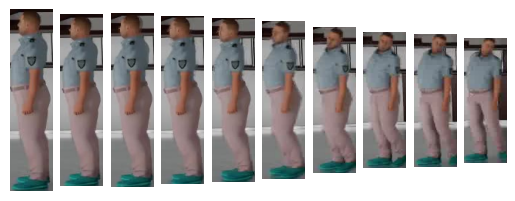

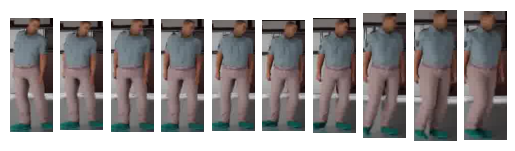

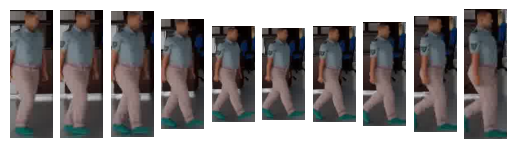

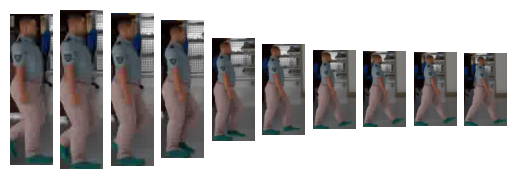

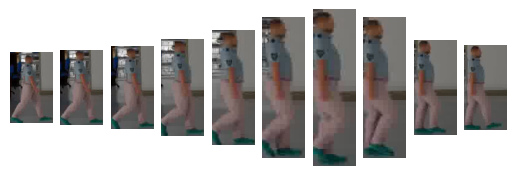

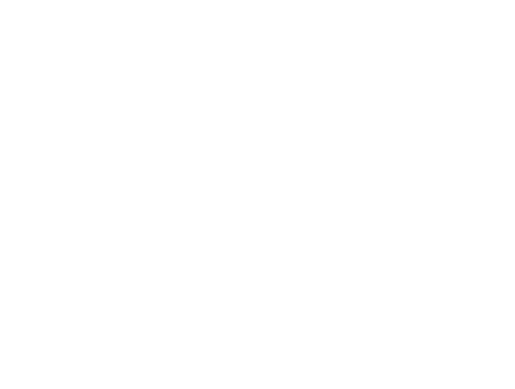

Detections with tracking ID #1:


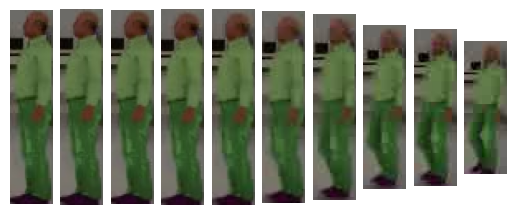

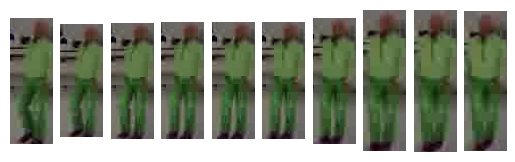

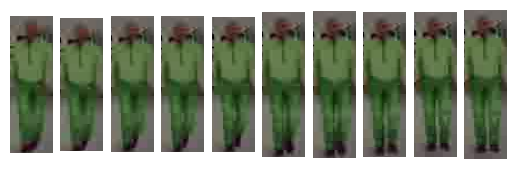

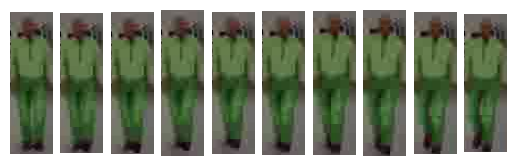

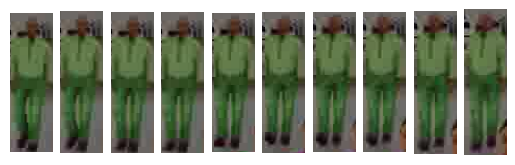

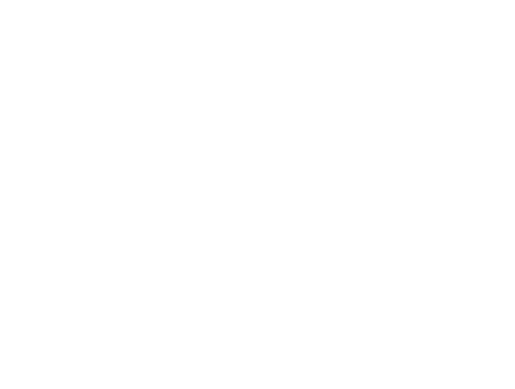

Detections with tracking ID #2:


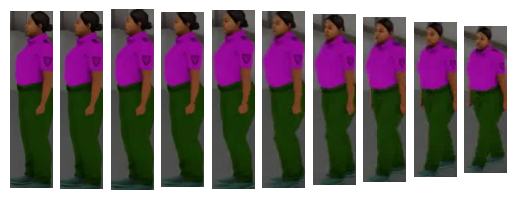

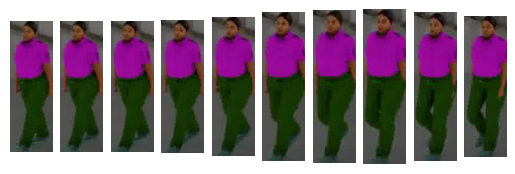

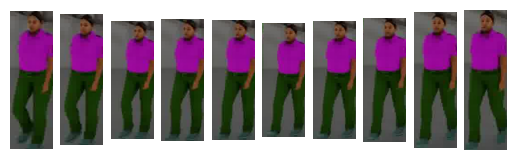

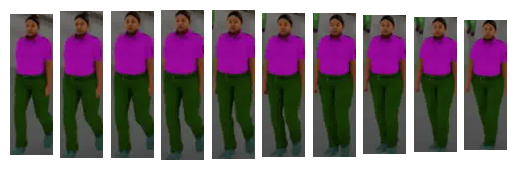

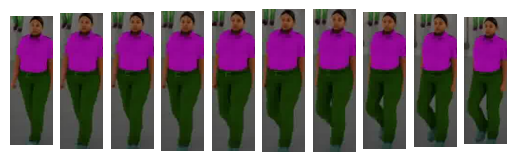

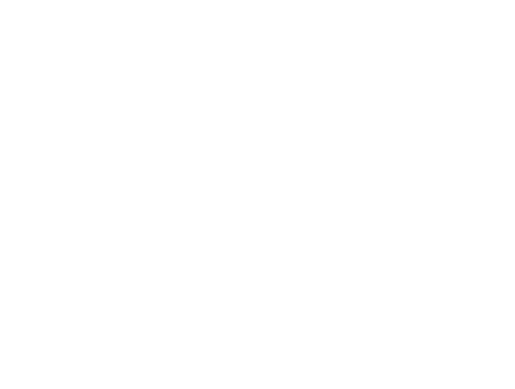

Detections with tracking ID #3:


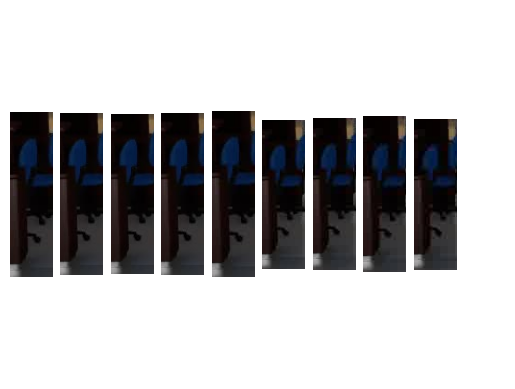

Detections with tracking ID #4:


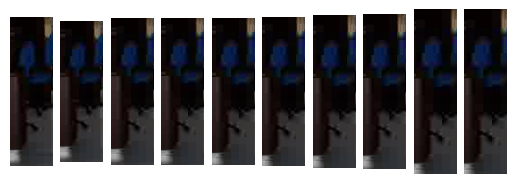

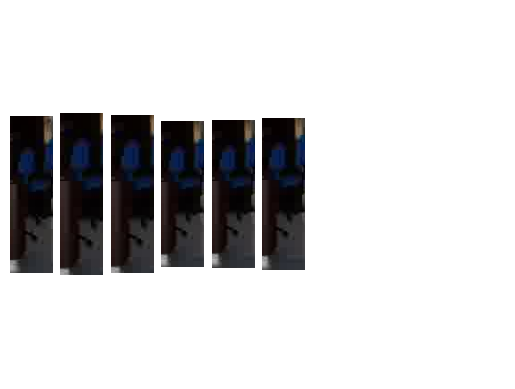

In [8]:
# Show tracking ids and associated detections
for i in range(len(ex_track_75.track_ids)):
    ex_track_75.show_track_id(i)

### 4.3.2: Post-processing ReID

In [9]:
# Test on training sets
out71 = MOT(71, 0.4, n_ppl=5, conf_thresh=0.3)
out71.make_txt("output71.txt")
out72 = MOT(72, 0.4, n_ppl=5, conf_thresh=0.3)
out72.make_txt("output72.txt")
out73 = MOT(73, 0.4, n_ppl=5, conf_thresh=0.3)
out73.make_txt("output73.txt")

| --- Detection 0, Frame 0 --- |
| --- Detection 3609, Frame 1000 --- |
| --- Detection 7142, Frame 2000 --- |
| --- Detection 10447, Frame 3000 --- |
| --- Detection 14053, Frame 4000 --- |
| --- Detection 17425, Frame 5000 --- |
| --- Detection 20820, Frame 6000 --- |
| --- Detection 24077, Frame 7000 --- |
| --- Detection 27193, Frame 8000 --- |
| --- Detection 30555, Frame 9000 --- |
| --- Detection 33926, Frame 10000 --- |
| --- Detection 37207, Frame 11000 --- |
| --- Detection 40490, Frame 12000 --- |
| --- Detection 43845, Frame 13000 --- |
| --- Detection 47054, Frame 14000 --- |
| --- Detection 50928, Frame 15000 --- |
| --- Detection 54866, Frame 16000 --- |
| --- Detection 57927, Frame 17000 --- |
| --- Detection 60676, Frame 18000 --- |
Beginning Post-Processing ReID
Post-Processing Complete
| --- Detection 0, Frame 0 --- |
| --- Detection 2691, Frame 1000 --- |
| --- Detection 5705, Frame 2000 --- |
| --- Detection 8547, Frame 3000 --- |
| --- Detection 11044, Frame 4000 

In [10]:
# POST-PROCESSING ReID
# Test on the Validation set
out74 = MOT(74, 0.4, n_ppl=5, conf_thresh=0.3)
out74.make_txt("output74.txt")

| --- Detection 0, Frame 0 --- |
| --- Detection 2444, Frame 1000 --- |
| --- Detection 4160, Frame 2000 --- |
| --- Detection 6111, Frame 3000 --- |
| --- Detection 8559, Frame 4000 --- |
| --- Detection 10628, Frame 5000 --- |
| --- Detection 12443, Frame 6000 --- |
| --- Detection 14189, Frame 7000 --- |
| --- Detection 16096, Frame 8000 --- |
| --- Detection 17656, Frame 9000 --- |
| --- Detection 18983, Frame 10000 --- |
| --- Detection 20328, Frame 11000 --- |
| --- Detection 22284, Frame 12000 --- |
| --- Detection 23996, Frame 13000 --- |
| --- Detection 25423, Frame 14000 --- |
| --- Detection 27615, Frame 15000 --- |
| --- Detection 29759, Frame 16000 --- |
| --- Detection 30849, Frame 17000 --- |
| --- Detection 32202, Frame 18000 --- |
Beginning Post-Processing ReID
Post-Processing Complete


## 4.2: Final Results

#### Best results: 
    ReID threshold = 0.4
    Conf. threshold = 0.3
    IDF1 Score on Validation set: 95.08%

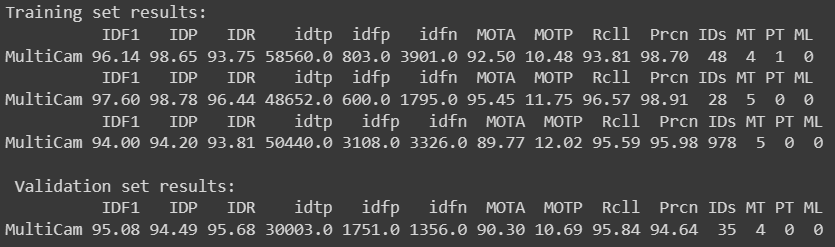

In [11]:
out75 = MOT(75, 0.4, n_ppl=5, conf_thresh=0.3)
out75.make_txt("final_output.txt")

| --- Detection 0, Frame 0 --- |
| --- Detection 3915, Frame 1000 --- |
| --- Detection 7922, Frame 2000 --- |
| --- Detection 12150, Frame 3000 --- |
| --- Detection 15684, Frame 4000 --- |
| --- Detection 19895, Frame 5000 --- |
| --- Detection 23833, Frame 6000 --- |
| --- Detection 27836, Frame 7000 --- |
| --- Detection 31303, Frame 8000 --- |
| --- Detection 35025, Frame 9000 --- |
| --- Detection 38921, Frame 10000 --- |
| --- Detection 43071, Frame 11000 --- |
| --- Detection 45626, Frame 12000 --- |
| --- Detection 49713, Frame 13000 --- |
| --- Detection 53984, Frame 14000 --- |
| --- Detection 58284, Frame 15000 --- |
| --- Detection 62567, Frame 16000 --- |
| --- Detection 66577, Frame 17000 --- |
| --- Detection 69655, Frame 18000 --- |
Beginning Post-Processing ReID
Post-Processing Complete
